In [3]:
from pathlib import Path
import yfinance as yf
import pandas as pd

DATA_DIR = Path("data")  # not ../data
RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

symbol = "BTC-USD"
start = "2016-01-01"
end = None  # today

df = yf.download(symbol, start=start, end=end, interval="1d", progress=False)
df.reset_index(inplace=True)
df.to_csv(RAW_DIR / f"{symbol}.csv", index=False)
print("Saved:", RAW_DIR / f"{symbol}.csv")


C:\Users\User\AppData\Local\Temp\ipykernel_15540\4180905232.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, interval="1d", progress=False)


Saved: data\raw\BTC-USD.csv


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pathlib import Path
sns.set_style("darkgrid")

DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
symbol = "BTC-USD"
start = "2016-01-01"
end = None  # None = up to today
df = yf.download(symbol, start=start, end=end, interval="1d", progress=False)
df.reset_index(inplace=True)
df.head()
# save raw
df.to_csv(RAW_DIR / f"{symbol}.csv", index=False)
print("Saved:", RAW_DIR / f"{symbol}.csv")


C:\Users\User\AppData\Local\Temp\ipykernel_15540\2458945632.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, interval="1d", progress=False)


Saved: ..\data\raw\BTC-USD.csv


In [6]:
import pandas as pd
import os

# ensure processed folder exists
os.makedirs("../data/processed", exist_ok=True)

# load the raw data
df = pd.read_csv("../data/raw/BTC-USD.csv", parse_dates=["Date"], index_col="Date")

# numeric columns (Adj Close removed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# daily frequency
df = df.asfreq("D")

# forward fill missing values
df = df.ffill()

# save cleaned data
df.to_csv("../data/processed/BTC-USD-clean.csv")

df.head()


,Close,High,Low,Open,Volume
Date,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900.0
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600.0
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800.0
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500.0
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600.0


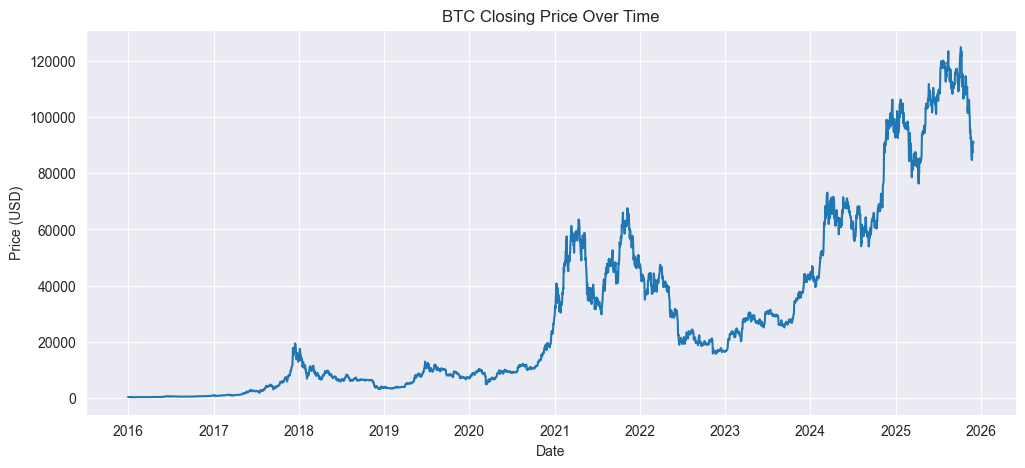

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["Close"])
plt.title("BTC Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' price for forecasting
data = df[["Close"]].values

# Scaling to 0–1 range
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Sequence length (how many past days the model sees)
sequence_length = 60  # 60 days history → predict next day

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

# Train-test split (80% train)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape


((2848, 60, 1), (713, 60, 1))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(60, 1)),
    Dropout(0.2),

    LSTM(64, return_sequences=False),
    Dropout(0.2),

    Dense(32),
    Dense(1)  # output: next day's price
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\User\crypto-forecast\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 4.5552e-04 - val_loss: 0.0052
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 4.0075e-04 - val_loss: 0.0028
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 3.5953e-04 - val_loss: 0.0020
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 3.6032e-04 - val_loss: 7.7137e-04
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 3.0657e-04 - val_loss: 0.0021
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 3.1813e-04 - val_loss: 0.0015
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 3.1720e-04 - val_loss: 0.0011
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 2.8955e-04 - val_loss: 0.0012
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 2.6227e-04 - val_loss: 0.0027
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 2.6317e-04 - val_loss: 9.2801e-04
Epoch 12/20

In [11]:
# Make predictions
predictions = model.predict(X_test)

# Undo scaling
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


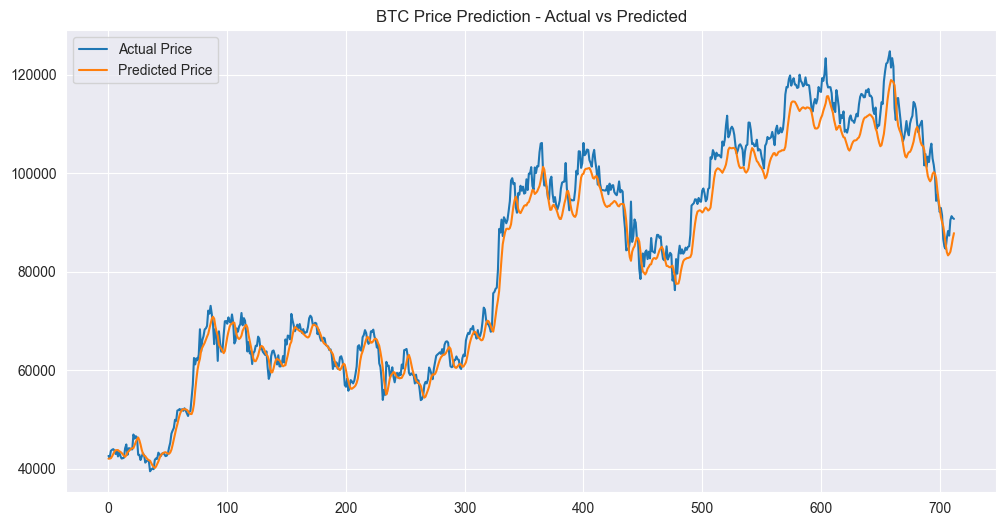

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.legend()
plt.title("BTC Price Prediction - Actual vs Predicted")
plt.show()


In [13]:
from pathlib import Path
import numpy as np

# --- 1️⃣ Save trained LSTM model ---
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model.save(MODELS_DIR / "lstm_model.h5")
print("LSTM model saved at:", MODELS_DIR / "lstm_model.h5")

# --- 2️⃣ Predict next 7 days ---
# Use the last 60 days of scaled data
last_60 = scaled_data[-60:]  # scaled_data from your preprocessing
future = []

current_input = last_60.reshape(1, 60, 1)

for _ in range(7):
    next_price = model.predict(current_input, verbose=0)[0][0]
    future.append(next_price)
    # append the new prediction to the input sequence
    current_input = np.append(current_input[:, 1:, :], [[[next_price]]], axis=1)

# Convert predictions back to original price scale
future_prices = scaler.inverse_transform(np.array(future).reshape(-1,1))

print("Next 7 days predicted BTC prices (USD):")
print(future_prices)


LSTM model saved at: ..\models\lstm_model.h5
Next 7 days predicted BTC prices (USD):
[[88540.54 ]
 [88369.58 ]
 [87800.95 ]
 [87032.055]
 [86157.36 ]
 [85226.52 ]
 [84269.05 ]]


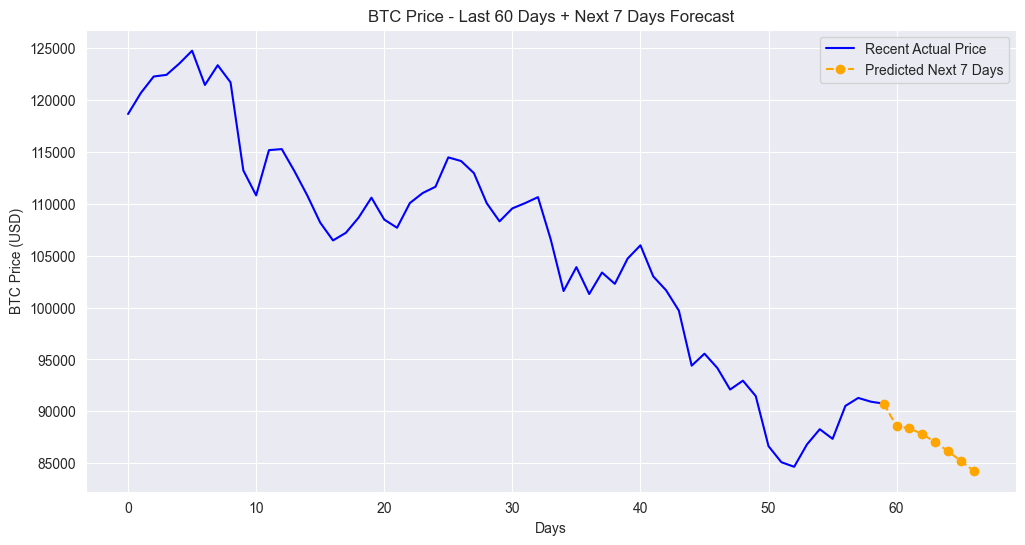

In [14]:
import matplotlib.pyplot as plt

# Last 60 days of actual prices
last_60_actual = df['Close'].values[-60:]

# Combine last 60 days and future predictions
combined = np.concatenate([last_60_actual, future_prices.flatten()])

# X-axis: days
days = np.arange(len(combined))

plt.figure(figsize=(12,6))
plt.plot(days[:60], last_60_actual, label="Recent Actual Price", color="blue")
plt.plot(days[59:], combined[59:], label="Predicted Next 7 Days", color="orange", linestyle="--", marker='o')
plt.title("BTC Price - Last 60 Days + Next 7 Days Forecast")
plt.xlabel("Days")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

# Last 60 days of actual prices
actual_prices = df['Close'].values[-60:]

# Future 7 days predicted by LSTM
scaled_last_60 = scaled_data[-60:].reshape(1, 60, 1)
future = []
current_input = scaled_last_60.copy()

for _ in range(7):
    next_price = model.predict(current_input, verbose=0)[0][0]
    future.append(next_price)
    current_input = np.append(current_input[:, 1:, :], [[[next_price]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future).reshape(-1,1)).flatten()

# Combine last 60 days + next 7 days
combined_dates = pd.date_range(start=df.index[-60], periods=60+7, freq='D')
combined_lstm = np.concatenate([actual_prices, future_prices])

# Create forecast DataFrame
reports_dir = Path("reports")
reports_dir.mkdir(exist_ok=True)

fc = pd.DataFrame({
    "date": combined_dates,
    "actual": np.concatenate([actual_prices, [np.nan]*7]),
    "lstm": combined_lstm,
    "arima": np.nan,    # placeholder
    "prophet": np.nan   # placeholder
})

# Save forecast CSV
fc.to_csv(reports_dir / "test_forecasts.csv", index=False)
print("Saved forecast CSV at:", reports_dir / "test_forecasts.csv")


Saved forecast CSV at: reports\test_forecasts.csv


In [16]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from prophet import Prophet
from pathlib import Path

# --- 1️⃣ ARIMA Forecast ---
def arima_forecast(df, forecast_days=7):
    train = df['Close']
    model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    forecast = model.predict(n_periods=forecast_days)
    last_60 = train.values[-60:]
    combined = np.concatenate([last_60, forecast])
    return combined

# --- 2️⃣ Prophet Forecast ---
def prophet_forecast(df, forecast_days=7):
    prophet_df = df[['Close']].reset_index().rename(columns={'Date':'ds', 'Close':'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    last_60 = df['Close'].values[-60:]
    prophet_pred = forecast['yhat'].values[-forecast_days:]
    combined = np.concatenate([last_60, prophet_pred])
    return combined

# --- Ensure reports directory exists ---
reports_dir = Path("reports")  # relative to root folder
reports_dir.mkdir(exist_ok=True)

# --- Forecasts ---
lstm_combined = combined_lstm          # from your LSTM predictions
arima_combined = arima_forecast(df)    # df is your cleaned data
prophet_combined = prophet_forecast(df) # df is your cleaned data

# --- Combine last 60 days + next 7 days for dates ---
combined_dates = pd.date_range(start=df.index[-60], periods=60+7, freq='D')

# --- Create final forecast DataFrame ---
fc = pd.DataFrame({
    "date": combined_dates,
    "actual": np.concatenate([df['Close'].values[-60:], [np.nan]*7]),
    "lstm": lstm_combined,
    "arima": arima_combined,
    "prophet": prophet_combined
})

# --- Save CSV ---
fc.to_csv(reports_dir / "test_forecasts.csv", index=False)
print("Updated forecast CSV with LSTM, ARIMA, Prophet at:", reports_dir / "test_forecasts.csv")


Updated forecast CSV with LSTM, ARIMA, Prophet at: reports\test_forecasts.csv


In [17]:
arima_combined = arima_forecast(df)
prophet_combined = prophet_forecast(df)

fc = pd.DataFrame({
    "date": combined_dates,
    "actual": np.concatenate([df['Close'].values[-60:], [np.nan]*7]),
    "lstm": combined_lstm,
    "arima": arima_combined,
    "prophet": prophet_combined
})

fc.to_csv(reports_dir / "test_forecasts.csv", index=False)


In [18]:
from pathlib import Path
import pandas as pd
import numpy as np

reports_dir = Path("reports")
reports_dir.mkdir(exist_ok=True)

# --- Forecasts from your previous LSTM, ARIMA, Prophet ---
lstm_combined = combined_lstm
arima_combined = arima_forecast(df)
prophet_combined = prophet_forecast(df)

# --- Correct date alignment ---
last_60_dates = list(df.index[-60:])  # historical
future_7_dates = list(pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=7))  # future
combined_dates = last_60_dates + future_7_dates

# --- Build final dataframe ---
fc = pd.DataFrame({
    "date": combined_dates,
    # Only historical Actual; future set to NaN
    "actual": list(df['Close'].values[-60:]) + [np.nan]*7,
    "lstm": lstm_combined,
    "arima": arima_combined,
    "prophet": prophet_combined
})

# --- Save CSV ---
fc.to_csv(reports_dir / "test_forecasts.csv", index=False)
print("Updated forecast CSV created")




Updated forecast CSV created


In [19]:
from fpdf import FPDF
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

# Paths
reports_dir = Path("reports")
reports_dir.mkdir(exist_ok=True)

# Load forecast CSV
fc = pd.read_csv(reports_dir / "test_forecasts.csv", parse_dates=["date"])

# --- Step 1: Create plot and save as image ---
plt.figure(figsize=(10,5))
plt.plot(fc['date'], fc['actual'], label="Actual")
plt.plot(fc['date'], fc['lstm'], label="LSTM")
plt.plot(fc['date'], fc['arima'], label="ARIMA")
plt.plot(fc['date'], fc['prophet'], label="Prophet")
plt.title("BTC Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plot_path = reports_dir / "forecast_plot.png"
plt.savefig(plot_path, bbox_inches='tight')
plt.close()

# --- Step 2: Create PDF ---
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "BTC Forecast Report", ln=True, align="C")

pdf.set_font("Arial", "", 12)
pdf.ln(10)
pdf.multi_cell(0, 8, "This report contains the last 60 days of actual BTC prices and forecasts for the next 7 days using LSTM, ARIMA, and Prophet models.", align="L")

pdf.ln(10)
pdf.image(str(plot_path), x=10, w=190)  # Insert the plot

# --- Step 3: Add a table of next 7 days forecast ---
pdf.add_page()
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "Next 7 Days Forecast", ln=True, align="C")

# Table header
pdf.set_font("Arial", "B", 12)
pdf.ln(5)
col_width = 40
pdf.cell(col_width, 8, "Date", 1)
pdf.cell(col_width, 8, "LSTM", 1)
pdf.cell(col_width, 8, "ARIMA", 1)
pdf.cell(col_width, 8, "Prophet", 1)
pdf.ln()

# Table rows (next 7 days only)
pdf.set_font("Arial", "", 12)
for i in range(-7, 0):
    pdf.cell(col_width, 8, fc['date'].iloc[i].strftime('%Y-%m-%d'), 1)
    pdf.cell(col_width, 8, f"{fc['lstm'].iloc[i]:.2f}", 1)
    pdf.cell(col_width, 8, f"{fc['arima'].iloc[i]:.2f}", 1)
    pdf.cell(col_width, 8, f"{fc['prophet'].iloc[i]:.2f}", 1)
    pdf.ln()

# Save PDF
pdf_file = reports_dir / "BTC_forecast_report.pdf"
pdf.output(pdf_file)
print("PDF report created at:", pdf_file)



PDF report created at: reports\BTC_forecast_report.pdf


In [20]:
df['Close'].values[-60:]


array([118648.9296875, 120681.2578125, 122266.53125  , 122425.4296875,
       123513.4765625, 124752.53125  , 121451.3828125, 123354.8671875,
       121705.5859375, 113214.3671875, 110807.8828125, 115169.765625 ,
       115271.078125 , 113118.6640625, 110783.1640625, 108186.0390625,
       106467.7890625, 107198.265625 , 108666.7109375, 110588.9296875,
       108476.890625 , 107688.5859375, 110069.7265625, 111033.921875 ,
       111641.7265625, 114472.4453125, 114119.328125 , 112956.1640625,
       110055.3046875, 108305.546875 , 109556.1640625, 110064.015625 ,
       110639.625    , 106547.5234375, 101590.5234375, 103891.8359375,
       101301.2890625, 103372.40625  , 102282.1171875, 104719.640625 ,
       105996.59375  , 102997.46875  , 101663.1875   ,  99697.4921875,
        94397.7890625,  95549.1484375,  94177.078125 ,  92093.875    ,
        92948.875    ,  91465.9921875,  86631.8984375,  85090.6875   ,
        84648.359375 ,  86805.0078125,  88270.5625   ,  87341.890625 ,
      

In [21]:
print(len(lstm_combined), len(arima_combined), len(prophet_combined))
print(len(combined_dates))


67 67 67
67
